# Hello World - Train an LLM from scratch

In [ ]:
!pip install nltk datasets
!pip install tqdm
!pip install transformers datasets accelerate
!pip install --upgrade transformers
!pip install peft transformers accelerate bitsandbytes
!pip install --upgrade peft

# Cấu hình

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

output_path = "/content/drive/MyDrive/unit test LLM for Cpp/20250206"
model_name = "Salesforce/codet5-base"

# Nơi lưu dataset chứa nhiều tệp json, mỗi tệp json lưu một tập test case
path = output_path + "/data"

# Nơi lưu mô hình học
MODEL = output_path + "/model"

# Tham số để chọn sample thỏa mãn (tránh học cả sample có số token quá lớn trên source/target). Điều này giúp mô hình học hiệu quả hơn.
max_source_length = 256
max_target_length = 256

# Tập dữ liệu học THÔ, chứa nhiều thông tin dư thừa
trainingset_raw = output_path + "/_AKA-LLM_merge.json"

# Tập dữ liệu học CHUẨN để sinh mô hình học (lấy từ tập dữ liệu học THÔ). Chỉ có đúng hai thuộc tính: source & target.
trainingset_finegrain = output_path + "/_AKA-LLM_merge_filtered.json"
prediction_path = output_path + "/_AKA-LLM_merge_prediction.csv"

# Lưu key của các thuộc tính trong tập training set THÔ
TS_RAW_FOCALMETHOD = "fm"; # hàm đang cần sinh ca kiểm thử
TS_RAW_METHOD = "m"         # hàm gọi/được gọi FM
TS_RAW_FOCALCLASS = "fc"        # class chứa FM
TS_RAW_PATH_FOCALMETHOD = "path_fm" # đường dẫn đến FM. Mỗi FM có một đường dẫn duy nhất
TS_RAW_FIELD = "f"          # Thuộc tính nằm trong TS_FOCALCLASS
TS_RAW_TEST = "t"           # Bộ test script đầy đủ (gồm tên + khởi tạo + gọi hàm FM + các câu lệnh khác của tool Aka-UT)

# Tập training set sau khi LÀM MỊN từ tập THÔ
TS_FINEGRAIN_SIMPLIFIED_SOURCE = "simplified_source"
TS_FINEGRAIN_SIMPLIFIED_TARGET = "simplified_target"
TS_FINEGRAIN_TOKEN_SIMPLIFIED_SOURCE = "num_token_of_simplified_source_CODET5"
TS_FINEGRAIN_TOKEN_SIMPLIFIED_TARGET = "num_token_of_simplified_target_CODET5"
TS_FINEGRAIN_FULL_TARGET = "full_target"
TS_FINEGRAIN_FULL_SOURCE = "full_source"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tiền xử lý tập training set sinh bởi AKAUT-LLM
Mã nguồn source, target ... tập training set chưa đủ tốt do nhiều thông tin nhiễu, ta cần loại bỏ các thông tin này

In [ ]:
import os
import glob
import json
import pandas as pd
from datasets import Dataset
from clang.cindex import Index, TokenKind
import re
from transformers import AutoTokenizer

# Load tokenizer của mô hình đang học
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Loại bỏ comment trong code
def remove_comments_ast(code):
    index = Index.create()
    tu = index.parse('temp.cpp', unsaved_files=[('temp.cpp', code)], args=['-x', 'c++'])
    comments = []

    for token in tu.cursor.get_tokens():
        if token.kind == TokenKind.COMMENT:
            comments.append((token.extent.start.offset, token.extent.end.offset))

    if not comments:
        return code

    result = ""
    last_end = 0
    for start, end in sorted(comments):
        result += code[last_end:start]
        last_end = end
    result += code[last_end:]
    return result

# Xoá những kí tự dư thừa như xuống dòng, nhiều dấu cách thừa ...
def clean_code(code):
    code = re.sub(r'[\r\n\t]+', ' ', code)
    code = re.sub(r'\s*;\s*', '; ', code)
    code = re.sub(r';\s*;', ';', code)
    code = re.sub(r'\s*{\s*', ' { ', code)
    code = re.sub(r'\s*}\s*', ' } ', code)
    code = re.sub(r'\s+', ' ', code)
    code = re.sub(r'\s*(,)\s*', r'\1 ', code)
    code = re.sub(r'\s*(=)\s*', r' \1 ', code)
    return code.strip()

# Hàm này chỉ lấy nội dung khởi tạo + gọi hàm
def extract_target_range(target):
    lines = target.split(';')
    code_lines = []
    capture = False

    for line in lines:
        if any(x in line for x in ['AKA_mark', 'AKA_EXPECTED_OUTPUT', 'AKA_fCall']):
            continue
        if 'AKA_test_case_name' in line:
            capture = True
            continue
        elif 'AKA_ACTUAL_OUTPUT' in line:
            code_lines.append(line.strip())
            break
        if capture:
            code_lines.append(line.strip())

    result = '; '.join(code_lines) if code_lines else target
    return result.lstrip(';').strip()

# Lấy các tệp training set nhỏ
json_files = glob.glob(os.path.join(path, "*.json"))
all_formatted_data = []

for raw_json_file in json_files:
    print("---------------------")
    with open(raw_json_file, "r", encoding="utf-8") as file:
        raw_data = json.load(file)
    print(f"Loaded {len(raw_data)} entries from {raw_json_file}")

    train_data = []
    for entry in raw_data:
        # Tạo source, target
        source = str(entry.get(TS_RAW_FOCALMETHOD, "")) + " " + " ".join(map(str, entry.get(TS_RAW_FIELD, [])))
        targets = entry.get(TS_RAW_TEST, [])

        for target in targets:
            # Tiền xử lý
            clean_source = clean_code(remove_comments_ast(source.strip()))
            simplified_target = clean_code(extract_target_range(remove_comments_ast(str(target).strip())))

            # Tính số token
            source_tokens = len(tokenizer.encode(clean_source))
            target_tokens = len(tokenizer.encode(simplified_target))

            # Lưu lại
            train_data.append({
                TS_FINEGRAIN_SIMPLIFIED_SOURCE: clean_source,
                TS_FINEGRAIN_SIMPLIFIED_TARGET: simplified_target,
                TS_FINEGRAIN_TOKEN_SIMPLIFIED_SOURCE: source_tokens,
                TS_FINEGRAIN_TOKEN_SIMPLIFIED_TARGET: target_tokens,
                TS_FINEGRAIN_FULL_TARGET: target,
                TS_FINEGRAIN_FULL_SOURCE: source
            })

    ###
    df = pd.DataFrame(train_data)
    hf_dataset = Dataset.from_pandas(df)
    formatted_data = [{
        TS_FINEGRAIN_SIMPLIFIED_SOURCE: sample[TS_FINEGRAIN_SIMPLIFIED_SOURCE],
        TS_FINEGRAIN_SIMPLIFIED_TARGET: sample[TS_FINEGRAIN_SIMPLIFIED_TARGET],
        TS_FINEGRAIN_TOKEN_SIMPLIFIED_SOURCE: sample[TS_FINEGRAIN_TOKEN_SIMPLIFIED_SOURCE],
        TS_FINEGRAIN_TOKEN_SIMPLIFIED_TARGET: sample[TS_FINEGRAIN_TOKEN_SIMPLIFIED_TARGET],
        TS_FINEGRAIN_FULL_SOURCE: sample[TS_FINEGRAIN_FULL_SOURCE],
        TS_FINEGRAIN_FULL_TARGET: sample[TS_FINEGRAIN_FULL_TARGET]
    } for sample in hf_dataset]

    all_formatted_data.extend(formatted_data)

    # Print
    if formatted_data:
        sample = formatted_data[0]
        print("\nSAMPLE DATA:")
        print("full_source:\t", repr(sample[TS_FINEGRAIN_FULL_SOURCE]))
        print("simplified_source:\t", repr(sample[TS_FINEGRAIN_SIMPLIFIED_SOURCE]))
        print("full_target:\t", repr(sample[TS_FINEGRAIN_FULL_TARGET]))
        print("simplified_target:\t[", repr(sample[TS_FINEGRAIN_SIMPLIFIED_TARGET]) + "]")
        print("simplified_source_tokens:", sample[TS_FINEGRAIN_TOKEN_SIMPLIFIED_SOURCE])
        print("simplified_target_tokens:", sample[TS_FINEGRAIN_TOKEN_SIMPLIFIED_TARGET])

# Export
with open(trainingset_raw, "w", encoding="utf-8") as f:
    json.dump(all_formatted_data, f, ensure_ascii=False, indent=4)
print(f"\nMerged JSON saved to {trainingset_raw}. Total samples: {len(all_formatted_data)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


---------------------
Loaded 4 entries from /content/drive/MyDrive/unit test LLM for Cpp/20250206/data/StructComparison.json

SAMPLE DATA:
full_source:	 'int compareTwoPeople(Person a, Person b){\r     if (strcmp(a.name, b.name)==0)\r         if (a.age==b.age)\r             if (a.salary==b.salary)\r                 return 1;\r \treturn 0;\r } '
simplified_source:	 'int compareTwoPeople(Person a, Person b) { if (strcmp(a.name, b.name) =  = 0) if (a.age =  = b.age) if (a.salary =  = b.salary) return 1; return 0; }'
full_target:	 'void AKA_TEST_compareTwoPeople_Person_Person_random_1(void) {\n{\nAKA_test_case_name="compareTwoPeople_Person_Person_random_1";\n\n// set up\n;\n\n\n\n\n\n\n\nint AKA_EXPECTED_OUTPUT;\n\n/* RootDataNode STATIC */\n/* StructDataNode a */\n/* SubStructDataNode a */\n/* ConstructorDataNode Person() */\nAKA_mark("Calling: \\\\Person()|ROOT\\\\StructComparison.cpp\\\\compareTwoPeople(Person,Person)\\\\a\\\\a\\\\Person()");AKA_fCall++;::Person a = ::Person();\n/* OneD

# Thống kê dữ liệu

<ipython-input-4-d5fa1dfd64b6>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Source', 'Target'])


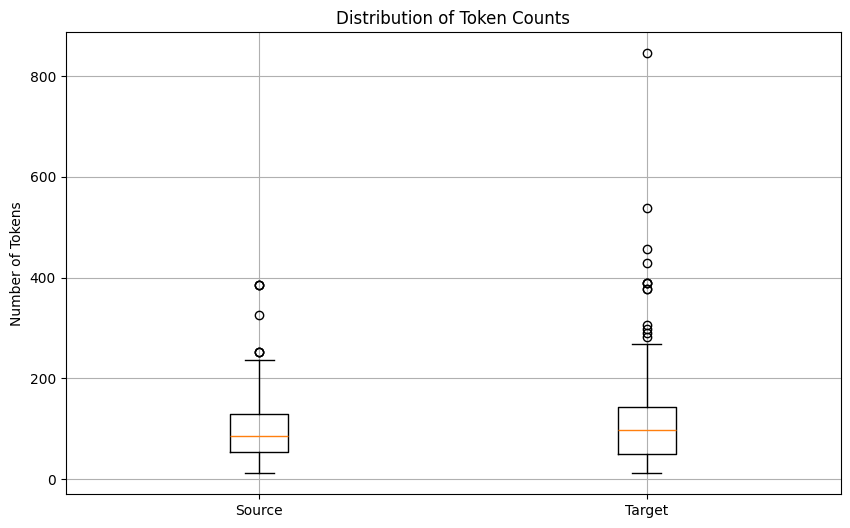

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

with open(trainingset_raw, "r", encoding="utf-8") as f:
   data = json.load(f)

source_tokens = [item[TS_FINEGRAIN_TOKEN_SIMPLIFIED_SOURCE] for item in data]
target_tokens = [item[TS_FINEGRAIN_TOKEN_SIMPLIFIED_TARGET] for item in data]

plt.figure(figsize=(10, 6))
box_data = [source_tokens, target_tokens]
plt.boxplot(box_data, labels=['Source', 'Target'])
plt.title('Distribution of Token Counts')
plt.ylabel('Number of Tokens')
plt.grid(True)
plt.show()

# Tạo tập dữ liệu CHUẨN

In [ ]:
import json

# Đọc và lọc dữ liệu
with open(trainingset_raw, "r", encoding="utf-8") as f:
   data = json.load(f)

filtered_data = [{"source": item[TS_FINEGRAIN_SIMPLIFIED_SOURCE],
                "target": item[TS_FINEGRAIN_SIMPLIFIED_TARGET]}
               for item in data
               if item[TS_FINEGRAIN_TOKEN_SIMPLIFIED_SOURCE] <= max_source_length
               and item[TS_FINEGRAIN_TOKEN_SIMPLIFIED_TARGET] <= max_target_length]

print(f"Original samples: {len(data)}")
print(f"Filtered samples: {len(filtered_data)}")

# Lưu dataset đã lọc
with open(trainingset_finegrain, "w", encoding="utf-8") as f:
   json.dump(filtered_data, f, ensure_ascii=False, indent=4)

print(f"Saved filtered dataset to: {trainingset_finegrain}")

Original samples: 148
Filtered samples: 129
Saved filtered dataset to: /content/drive/MyDrive/unit test LLM for Cpp/20250206/_AKA-LLM_merge_filtered.json


# Train model - Autoregressive approach

In [ ]:
from datasets import load_dataset


dataset = load_dataset("json", data_files=trainingset_finegrain, split="train")

# Chia tập dữ liệu thành train (90%) và validation (10%)
train_validation_split = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)

train_dataset = train_validation_split["train"]
validation_dataset = train_validation_split["test"]  # Đổi tên thành validation

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(validation_dataset))

Generating train split: 0 examples [00:00, ? examples/s]

Train dataset size: 116
Validation dataset size: 13


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments
from datasets import load_dataset
import torch
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import random
from transformers import TrainerCallback
from torch.optim import AdamW
from peft import LoraConfig, get_peft_model

# Load the tokenizer, model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Cấu hình LoRA
lora_config = LoraConfig(
    r=8,  # Rank (kích thước ma trận bổ sung)
    lora_alpha=32,  # Hệ số scale cho LoRA
    target_modules=["q", "v"],  # Áp dụng LoRA vào các module Attention
    lora_dropout=0.1,  # Dropout cho LoRA
    bias="none",  # Không tinh chỉnh bias
    task_type="SEQ_2_SEQ_LM"  # Loại tác vụ (Sequence-to-Sequence)
)

# Tích hợp LoRA vào mô hình
model = get_peft_model(model, lora_config)

# Kiểm tra số lượng tham số có thể tinh chỉnh
model.print_trainable_parameters()

# Add <SEP>
# special_tokens_dict = {"additional_special_tokens": ["<SEP>"]}
# tokenizer.add_special_tokens(special_tokens_dict)
# model.resize_token_embeddings(len(tokenizer))

def preprocess_function_with_masking(examples):
    sources = [
        str(source) + " <SEP>" for source in examples["source"]
    ]
    targets = [str(target) for target in examples["target"]]

    # Tokenize source
    model_inputs = tokenizer(
        sources, max_length=max_source_length, truncation=True, padding="max_length"
    )

    # Tokenize target
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, max_length=max_target_length, truncation=True, padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def preprocess_function(examples):
    sources = [str(source) + " <SEP>" for source in examples["source"]]
    targets = [str(target) for target in examples["target"]]

    # Tokenize source
    model_inputs = tokenizer(
        sources, max_length=max_source_length, truncation=True, padding="max_length"
    )

    # Tokenize target
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, max_length=max_target_length, truncation=True, padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_dataset.map(preprocess_function_with_masking, batched=True) # masking
validation_dataset = validation_dataset.map(preprocess_function_with_masking, batched=True) # masking

optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
training_args = TrainingArguments(
   output_dir="./results",
   evaluation_strategy="epoch",
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=200, # SỐ EPOCH <-------------------------------------------------------------------------------------------------------------------------
   weight_decay=0.01,
   logging_strategy="epoch",
   save_total_limit=2,
   save_steps=500,
   logging_dir="./logs",
   logging_steps=50,
   fp16=True,
   report_to="none",
   optim="adamw_torch"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, None)
)

trainer.train()

# Save
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

# Evaluate the model
results = trainer.evaluate()
print("Evaluation results:", results)


trainable params: 884,736 || all params: 223,766,784 || trainable%: 0.3954


Map:   0%|          | 0/116 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-7daf8581e383>:94: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.906700,5.879181
2,4.583700,1.277442
3,1.051900,0.877575
4,0.776800,0.704970
5,0.594600,0.485150
6,0.440100,0.396486
7,0.389500,0.364190
8,0.338300,0.307855
9,0.302400,0.278644
10,0.275500,0.261039


/usr/local/lib/python3.11/dist-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error 500 Server Error: Internal Server Error for url: https://huggingface.co/Salesforce/codet5-base/resolve/main/config.json (Request ID: Root=1-67a98c21-55991c370ced299552a4ef59;03503680-38e3-4920-8501-da75c2fa060d)

The request is taking longer than expected, please try again later. - silently ignoring the lookup for the file config.json in Salesforce/codet5-base.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in Salesforce/codet5-base - will assume that the vocabulary was not modified.
  warnings.warn(


Evaluation results: {'eval_loss': 0.2820632755756378, 'eval_runtime': 0.0789, 'eval_samples_per_second': 164.664, 'eval_steps_per_second': 12.666, 'epoch': 200.0}


# Model evaluation

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import csv
import os
import torch

# Load dataset
dataset = load_dataset("json", data_files=trainingset_finegrain, split="train")
train_validation_split = dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)
train_dataset = train_validation_split["train"]

def safe_csv_value(value):
    """ Đảm bảo dữ liệu không gây lỗi khi xuất CSV """
    if isinstance(value, str):
        return value.replace('"', '""')  # Xử lý dấu nháy kép
    return value

def generate_target_from_sample(sample, tokenizer, model):
    source_text = str(sample["source"]) + " <SEP>"
    inputs = tokenizer(source_text, return_tensors="pt", max_length=max_source_length, truncation=True)
    inputs = {key: value.to(model.device) for key, value in inputs.items()}
    outputs = model.generate(inputs=inputs["input_ids"], max_length=max_target_length)
    generated_target = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return source_text, generated_target

def exact_match(generated, ground_truth):
    return generated.strip() == ground_truth.strip()

def compute_bleu(generated, ground_truth):
    generated_tokens = generated.split()
    ground_truth_tokens = ground_truth.split()
    return sentence_bleu([ground_truth_tokens], generated_tokens)

def evaluate_on_dataset(dataset, tokenizer, model, prediction_path):
    # Xoá file output nếu đã có
    if os.path.exists(prediction_path):
        os.remove(prediction_path)

    em_scores = []
    bleu_scores = []

    with open(prediction_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_ALL)
        writer.writerow(['Source', 'Expected Target', 'Predicted Target', 'BLEU Score', 'Exact Match'])

        pbar = tqdm(dataset, desc="Evaluating", unit="sample")
        for sample in pbar:
            source_text, generated_target = generate_target_from_sample(sample, tokenizer, model)
            ground_truth_target = str(sample["target"])

            em_score = exact_match(generated_target, ground_truth_target)
            bleu_score = compute_bleu(generated_target, ground_truth_target)

            writer.writerow([safe_csv_value(source_text), safe_csv_value(ground_truth_target),
                             safe_csv_value(generated_target), bleu_score, em_score])
            f.flush()

            em_scores.append(em_score)
            bleu_scores.append(bleu_score)

            pbar.set_postfix(EM=f"{100*sum(em_scores)/len(em_scores):.2f}%",
                             BLEU=f"{100*sum(bleu_scores)/len(bleu_scores):.2f}%")

    return sum(em_scores)/len(em_scores), sum(bleu_scores)/len(bleu_scores)

# Đánh giá
em_avg, bleu_avg = evaluate_on_dataset(train_dataset, tokenizer, model, prediction_path)

# In final result
print(f"\nAverage Exact Match: {em_avg * 100:.2f}%")
print(f"Average BLEU Score: {bleu_avg * 100:.2f}%")

Evaluating: 100%|██████████| 116/116 [04:18<00:00,  2.23s/sample, BLEU=99.07%, EM=98.28%]


Average Exact Match: 98.28%
Average BLEU Score: 99.07%


# Load model from file

In [ ]:
from transformers import T5ForConditionalGeneration, AutoTokenizer, T5Config

def load_codet5_model(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    config = T5Config.from_pretrained(model_path)
    config.vocab_size = len(tokenizer)
    model = T5ForConditionalGeneration.from_pretrained(
        model_path,
        config=config,
        device_map="auto",
        torch_dtype="auto"
    )

    print(f"Tokenizer vocab size: {len(tokenizer)}")
    print(f"Model vocab size: {model.config.vocab_size}")

    return model, tokenizer

model, tokenizer = load_codet5_model(MODEL)

def generate_code(prompt, model, tokenizer, max_length=512):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=1,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )

    generated_code = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_code

Tokenizer vocab size: 32100
Model vocab size: 32100
